# **Deforum Google Colab**
Deforum for Google Colab. Generate animations with diffusion models. Features include: text-to-video, image-to-video, video-to-video, and keyframe camera motions. Supports SD1.5, SDXL, and SD3. Built on top of diffusers. Notebook by [Huemin](https://www.huemin.art)

In [1]:
#@markdown **SETUP ENVIRONMENT**
import subprocess, os, sys
sub_p_res = subprocess.run(['nvidia-smi', '--query-gpu=name,memory.total,memory.free', '--format=csv,noheader'], stdout=subprocess.PIPE).stdout.decode('utf-8')
print(f"{sub_p_res[:-1]}")

models_path = "/content/models"
output_path = "/content/output"

# Mount Google Drive
mount_google_drive = True
force_remount = False

if mount_google_drive:
    from google.colab import drive
    try:
        drive_path = "/content/drive"
        drive.mount(drive_path,force_remount=force_remount)
        models_path_gdrive = "/content/drive/MyDrive/AI/models"
        output_path_gdrive = "/content/drive/MyDrive/AI/outputs"
        models_path = models_path_gdrive
        output_path = output_path_gdrive
    except:
        print("...error mounting drive or with drive path variables")
        print("...reverting to default path variables")

import os
os.makedirs(models_path, exist_ok=True)
os.makedirs(output_path, exist_ok=True)

print(f"models_path: {models_path}")
print(f"output_path: {output_path}")

# install stuff
!git clone https://github.com/huemin-art/deforum-google-colab.git
!pip install -q diffusers transformers accelerate

NVIDIA L4, 23034 MiB, 22698 MiB
Mounted at /content/drive
models_path: /content/drive/MyDrive/AI/models
output_path: /content/drive/MyDrive/AI/outputs
Cloning into 'deforum-google-colab'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 8), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (22/22), 20.77 KiB | 20.77 MiB/s, done.
Resolving deltas: 100% (8/8), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 70.6 MB/s eta 0:00:00


In [2]:
# required for sd3
!huggingface-cli login

# The secret `HF_TOKEN` does not exist in your Colab secrets.
# To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
# You will be able to reuse this secret in all of your notebooks.
# Please note that authentication is recommended but still optional to access public models or datasets.


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


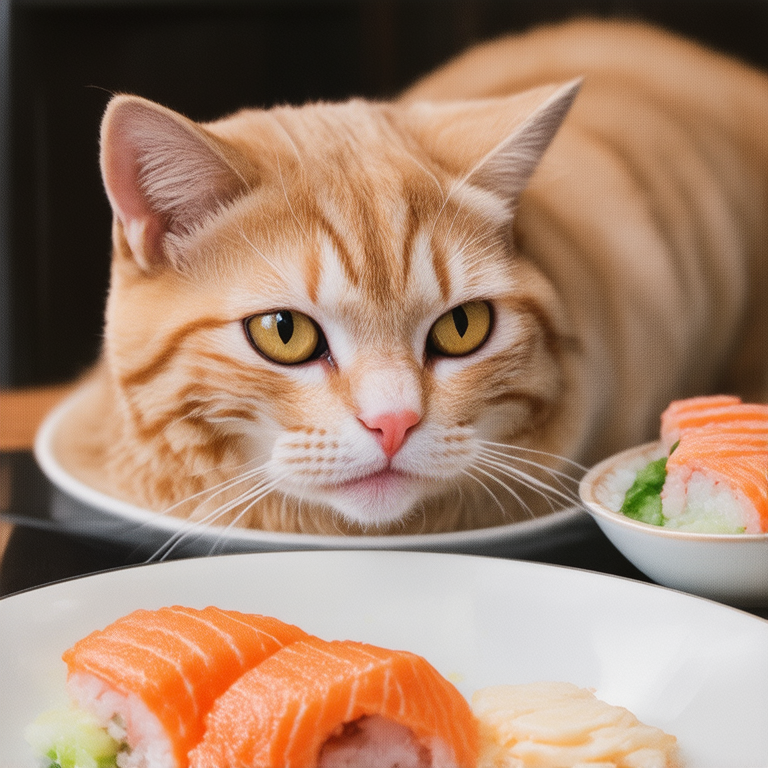

Animation saved as test.mp4


In [3]:
from re import T
import torch
from pydantic import BaseModel, computed_field
from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image
from IPython.display import display, clear_output, Video
from tqdm.notebook import trange

sys.path.append(os.path.join(os.getcwd(), "deforum-google-colab"))

from helpers import load_image, create_animation_from_pil_images

#@markdown **RUN MODE**
mode = "animation" #@param ["image", "animation"]

model_map = {
    "sd3-medium": {
        "model": "stabilityai/stable-diffusion-3-medium-diffusers",
        "device": "cuda",
        "variant": None,
        "safetensors": False,
        "torch_dtype": "float16"
    },
    "sdxl-protovisionxl": {
        "model": "stablediffusionapi/protovision-xl-high-fidel",
        "device": "cuda",
        "variant": None,
        "safetensors": False,
        "torch_dtype": "float16"
    },
    "sdxl-base": {
        "model": "stabilityai/stable-diffusion-xl-base-1.0",
        "device": "cuda",
        "variant": "fp16",
        "safetensors": True,
        "torch_dtype": "float16"
    }
}

#@markdown **MODEL SETTINGS**
class DeforumConfig(BaseModel):
    name: str = "sd3-medium" #@param ["sdxl-protovisionxl", "sdxl-base-sdxl","sd3-medium"]
    model: str = ""
    device: str = "cuda"
    variant: str = None
    safetensors: bool = True
    torch_dtype: str = "float16"

    def __init__(self, **data):
        super().__init__(**data)
        self.update_from_model_map()

    def update_from_model_map(self):
        if self.name in model_map:
            config = model_map[self.name]
            for key, value in config.items():
                setattr(self, key, value)

#@markdown **IMAGE SETTINGS**
class DeforumArgs(BaseModel):
    prompt: str = "cat sushi" #@param {type:"string"}
    negative_prompt: str = "" #@param {type:"string"}
    width: str = 768 #@param [256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536]
    height: int = 768 #@param [256, 320, 384, 448, 512, 576, 640, 704, 768, 832, 896, 960, 1024, 1088, 1152, 1216, 1280, 1344, 1408, 1472, 1536]
    num_inference_steps: int = 20 #@param {type:"integer"}
    guidance_scale: float = 4.0 #@param {type:"number"}
    strength: float = 0.5 #@param {type:"number"}
    init_image: str = "" #@param {type:"string"}

#@markdown **ANIMATION SETTINGS**
class DeforumAnimationArgs(BaseModel):
    duration_seconds: int = 2 #@param {type:"integer"}
    frames_per_second: int = 12 #@param {type:"integer"}

    @computed_field
    def max_frames(self) -> int:
        return self.duration_seconds * self.frames_per_second

def get_txt2img(config):
    if config.name == "sd3-medium":
        from diffusers import StableDiffusion3Pipeline, StableDiffusion3Img2ImgPipeline
        txt2img = StableDiffusion3Pipeline.from_pretrained(
            config.model,
            torch_dtype=getattr(torch, config.torch_dtype)
        ).to(config.device)
        img2img = StableDiffusion3Img2ImgPipeline.from_pipe(txt2img)
    else:
        txt2img = AutoPipelineForText2Image.from_pretrained(
            config.model,
            torch_dtype=getattr(torch, config.torch_dtype),
            variant=config.variant,
            use_safetensors=config.safetensors
        ).to(config.device)
        img2img = AutoPipelineForImage2Image.from_pipe(txt2img)

    return txt2img, img2img

class DeforumGenerator:
    def __init__(self, config: DeforumConfig):
        self.config = config
        self.txt2img, self.img2img = get_txt2img(config)

        # state
        self.init = None
        self.frames = []

    def generate_image(self, args: DeforumArgs):

        if self.init is None:
            self.init = load_image(args.init_image)

        if self.init is None:
            image = self.txt2img(
                prompt=args.prompt,
                negative_prompt=args.negative_prompt,
                width=args.width,
                height=args.height,
                num_inference_steps=args.num_inference_steps,
                guidance_scale=args.guidance_scale
            ).images[0]
        else:
            image = self.img2img(
                prompt=args.prompt,
                image=self.init,
                negative_prompt=args.negative_prompt,
                num_inference_steps=args.num_inference_steps,
                guidance_scale=args.guidance_scale,
                strength=args.strength
            ).images[0]

        image.save("output.png")
        clear_output(wait=True)
        display(image)

        return image


    def generate_animation(self, args: DeforumArgs, anim_args: DeforumAnimationArgs):

        # reset
        self.init = None
        self.frames = []

        # loop
        for i in trange(anim_args.max_frames):
            print(args)
            self.init = self.generate_image(args)
            self.frames.append(self.init)

        # video
        create_animation_from_pil_images(
            self.frames,
            "test.mp4",
            fps=anim_args.frames_per_second,
            loop=0,
            crf=17
        )

        Video("test.mp4", embed=True)


if __name__ == "__main__":
    if "deforum" not in globals():
        config = DeforumConfig()
        deforum = DeforumGenerator(config)

    args = DeforumArgs()
    anim_args = DeforumAnimationArgs()

    if mode == "image":
        print(args)
        deforum.generate_image(args)
    if mode == "animation":
        print(anim_args)
        deforum.generate_animation(args, anim_args)
